# Test For Data Analyst Position at JobTech
## Analysis

### Environment parameters

In [1]:
path_drive = 'C:/Users/adam2/Documents/data_analyst_test'

In [2]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import re
import string
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score

### Import data

In [3]:
df = pd.read_csv(f'{path_drive}/test_data.txt',
                 sep='\t', header=0)
df.shape

(3000, 5)

In [4]:
df.head()

,job_id,job_title,job_description,date_posted,company_name
0,dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...,BUSINESS DEVELOPMENT (FREIGHT FORWARDING),- Roles &amp; Responsibilities : Job Role Desc...,2020-11-27,CALL LADE ENTERPRISES PTE LTD
1,39fc119781f2337a52de7300f21b76cda9b2c0202bfec9...,Secretary/PA,- Roles &amp; Responsibilities : Job Scope:<br...,2020-11-26,TALENT TRADER GROUP PTE. LTD.
2,2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...,Temporary 3-6months Admin Assistant (Office ho...,Monday to Friday Office hoursLocation : Buona ...,2020-11-14,Confidential
3,0c170932727e0246f27feb1a5641d0e26f44d26d431be6...,Program Management,- Roles &amp; Responsibilities : Key Responsib...,2020-11-09,YASH TECHNOLOGIES SINGAPORE PTE. LIMITED
4,458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...,Automotive Software Engineers (C Programming /...,&bull; MNC&bull; $3500 - $6000 Basic + AWS + V...,2020-11-15,Confidential


### Simple wordcloud on job_description and job_title

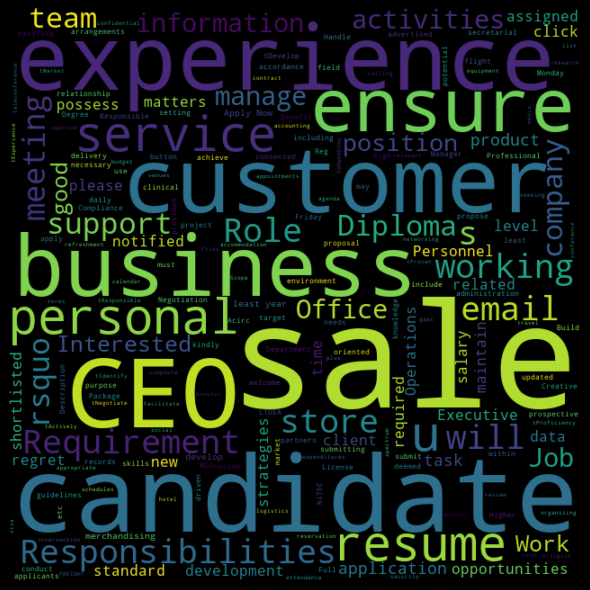

In [5]:
stop_words = STOPWORDS.update([
    "br", "nbsp", "Oslash", "amp",
    "quot", "bull", "pte", "ltd'"
])

jd = df['job_description'].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = stop_words)\
    .generate(str(jd))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud,
           interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

*Noted that the words such as candidate, experience and sale are commonly used in the job_description*

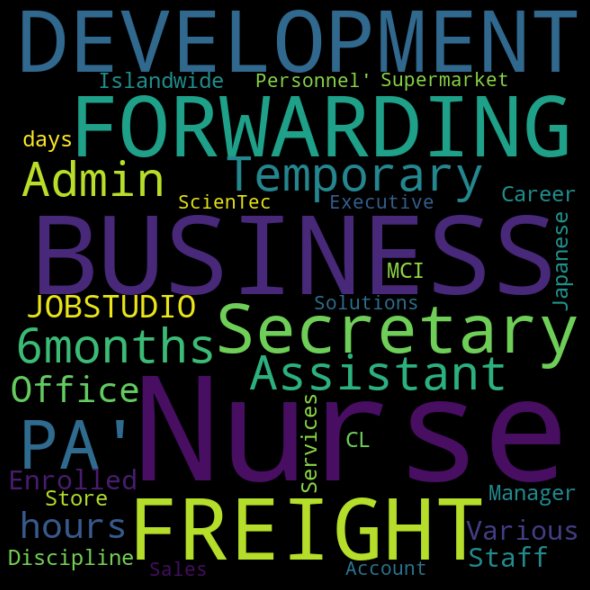

In [6]:
jt = df['job_title'].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = stop_words)\
    .generate(str(jt))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud,
           interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

*Noted that there nurses, secretary and business-related jobs are the common job_title in the data set*

### Data Cleaning

(i) Slight cleaning to explore if there is anything interesting from company that posted

In [7]:
df["coy"] = [coy.lower() for coy in df.company_name]

In [8]:
df.coy = [re.sub(" pte.*", "",  coy) for coy in df.coy]
df.coy = [re.sub(" ltd.*", "",  coy) for coy in df.coy]
df.coy = [re.sub(" limited", "",  coy) for coy in df.coy]

In [9]:
print(f'Approximate number of companies: {len(set(df.coy))}')
print(f'Example: {list(set(df.coy))[:5]}')

Approximate number of companies: 887
Example: ['star array', 'skillsforce management consultancy', 'acme supplies', 'ups asia group', 'a new u beauty & wellness']


In [10]:
count_by_coy = df.coy.value_counts()
count_by_coy[:5]

confidential      1516
locanto            133
recruitexpress      84
recruit expert      25
dbs bank            17
Name: coy, dtype: int64

*More than half the records are posted by confidential entities. The next three highest count were by job recruiters.*

(ii) Examining the two most popular job_titles - nurse and secretary

In [11]:
df['nurse'] = [
    ''.join(re.findall('nurse',
                       job_title.
                       lower())) for job_title in df.job_title
]

df.nurse = df.nurse.replace({
    '': 0, 'nurse': 1, 'nursenurse': 1,
    'nursenursenurse': 1
})

print(f'Number of posting containing "nurse": {df.nurse.sum()}')
print(f"Examples:\n {[list for list in df[df['nurse']==1]['job_title'][:5]]}")

Number of posting containing "nurse": 42
Examples:
 ['Senior / Staff Nurse, Home Care - ASSISI HOSPICE', 'Locum / Agency Nurse (1 - 3 Months / Flexible) - HYN - RECRUIT EXPRESS PTE LTD', 'Senior/Staff Nurse (Up to $5500/O&G/Delivery Suite /Operating Theatre) - Search Index Pte Ltd', 'Staff Nurse (Inpatient) - 1265BR - National Heart Centre Singapore', 'Staff Nurse/Senior (ICU/NICU/A&E/OT) APPLY NOW ! REF : JC - JOBSTUDIO PTE LTD']


In [12]:
df['secretary'] = [
    ''.join(re.findall('secretary',
                       job_title.
                       lower())) for job_title in df.job_title
]
df.secretary = df.secretary.replace({'': 0, 'secretary': 1})

print(f'Number of posting containing "secretary": {df.secretary.sum()}')
print(f"Examples:\n {[list for list in df[df['secretary']==1]['job_title'][:5]]}")

Number of posting containing "secretary": 7
Examples:
 ['Secretary/PA', 'Corporate Secretary Executive #SGUP', 'Executive Secretary/ PA/ Central - Talent Trader Group Pte Ltd', 'Corporate Secretary', 'Legal Secretary for Law Firm']


### Predicting if a job description is asking for a nursing position

(i) Preprocessing job descripton

In [13]:
def preprocess(text):
    '''
    Removes punctuation from a string, and converts all characters to lowercase.
    Splits hyphenated words into two words.
    Remove html tags.
    '''
    preprocessed_text = text.lower().replace('-', ' ')
    preprocessed_text = re.compile(r'<[^>]+>').sub(' ', preprocessed_text)
    preprocessed_text = re.compile(r'&[^>]+;').sub(' ', preprocessed_text)
    preprocessed_text = preprocessed_text.translate(str.maketrans('', '', string.punctuation))
    preprocessed_text = preprocessed_text.replace('\t', ' ')
    preprocessed_text = preprocessed_text.replace('\n', ' ')
    return preprocessed_text

In [14]:
df['description'] = [preprocess(sentence) for sentence in df['job_description']]

In [15]:
df.head()

,job_id,job_title,job_description,date_posted,company_name,coy,nurse,secretary,description
0,dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...,BUSINESS DEVELOPMENT (FREIGHT FORWARDING),- Roles &amp; Responsibilities : Job Role Desc...,2020-11-27,CALL LADE ENTERPRISES PTE LTD,call lade enterprises,0,0,roles market knowledge
1,39fc119781f2337a52de7300f21b76cda9b2c0202bfec9...,Secretary/PA,- Roles &amp; Responsibilities : Job Scope:<br...,2020-11-26,TALENT TRADER GROUP PTE. LTD.,talent trader group,0,1,roles personal assistant or equivalent ful...
2,2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...,Temporary 3-6months Admin Assistant (Office ho...,Monday to Friday Office hoursLocation : Buona ...,2020-11-14,Confidential,confidential,0,0,monday to friday office hourslocation buona v...
3,0c170932727e0246f27feb1a5641d0e26f44d26d431be6...,Program Management,- Roles &amp; Responsibilities : Key Responsib...,2020-11-09,YASH TECHNOLOGIES SINGAPORE PTE. LIMITED,yash technologies singapore,0,0,roles itil foundation advantageous
4,458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...,Automotive Software Engineers (C Programming /...,&bull; MNC&bull; $3500 - $6000 Basic + AWS + V...,2020-11-15,Confidential,confidential,0,0,s site requirements degree in relevant disc...


(ii) vectorizing data

- As there are only 42 counts of nursing position, I will take the whole data set as training set, and attempt to use external job posting description as testing data

In [16]:
description_train = [v for v in df.description]
y_train = [v for v in df.nurse]

In [17]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(description_train)
X_train

<3000x16953 sparse matrix of type '<class 'numpy.int64'>'
	with 219595 stored elements in Compressed Sparse Row format>

### Initializing Model Parameters and Training

In [18]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB()

### Vectorizing Validation Data and Evaluating Model
I have taken 5 job ads to test the naive bayes classification - 3 are nursing jobs and 2 are secretary jobs:


- [Assistant nurse manager](https://www.mycareersfuture.gov.sg/job/healthcare/assistant-nurse-manager-fixed-5-days-yishun-9156-supreme-hr-advisory-7c349a7b3430d3aae26d2114d9d1f7c5)
- [Enrolled nurse](https://www.mycareersfuture.gov.sg/job/healthcare/enrolled-nurse-staffondemand-be713028e06e36ced294578cb22365e6)
- [CCLE - Staff nurse/Enrolled nurse](https://www.mycareersfuture.gov.sg/job/healthcare/ccle-staff-nurse-enrolled-nurse-nursing-home-6-days-shift-yishun-supreme-hr-advisory-86fb11e4783959338ad039cdaf6f0891)
- [Assistant sales secretary](https://www.mycareersfuture.gov.sg/job/admin/assistant-sales-secretary-talentintent-search-consulting-ae78a041c68545b08f10db85aac6e5b4)
- [Personal assistant cum secretary](https://www.mycareersfuture.gov.sg/job/admin/personal-assistant-cum-secretary-beautex-interior-7a0628ad0f775fbfbf8aabc742194350)


In [19]:
ad_1 = """
• Responsible for the professional nursing care of all residents by overseeing daily operations by ensuring shifts are adequately staffed.

• Utilises a holistic and multifaceted approach to plan and execute care to meet residents’ care needs and ensure that the Home’s nursing services meet and adhere to regulations and licensing requirements.

• Liaise between the Nursing department and medical practitioners, dietitian and pharmacists as needed to help facilitate residents’ care.

• Deputise in the absence of the Nurse Manager and acts as a resource person for Staff Nurses and below within the Nursing department.

• Assist the Nurse Manager in coordinating and facilitating nursing care services according to established standards in the management of residential care units. Evaluate resident care activities and recommend improvements.

• Plan and schedule daily work for nursing staffs work with Nurse Manager to determine staffing requirements and shift schedules.

Educate and supervise conduct of correct nursing practices and high service standards beside supervise and guide nurses in providing quality care to ensure residents’ satisfaction and safety.

Monitor performance of all categories of staff from Staff Nurses and below and provide feedback to the Nurse Manager.

Monitor and evaluate nursing workflows, systems and processes to bring about safe, competent, compassionate and holistic care.

Coordinate and oversee induction and orientation programs to new staff, promoted or re-designated staff to meet role and work requirements of the job. Induct new staff personally if required.

Conduct performance appraisal and counselling of staff on unprofessional conduct and practices.

Supervises and provides clinical guidance to the healthcare team by being actively involved in direct resident care.

Identifying and presenting resident care issues for professional transdisciplinary discussions at clinical conference and other platforms.

Conducting nursing rounds to identify clinical and service issue with the aim of addressing and closing gaps in care.

Communicating and collaborating with intra- and inter-departmental staff, residents and relatives.

Performs other duties as assigned by the Director of Nursing.
"""
ad_1 = preprocess(ad_1)

In [20]:
ad_2 = """
    Responsible for the admission and orientation of new residents
    Carry out nursing rounds with Registered Nurse and assist in the delivery of nursing care
    Check, monitor and record residents’ vital sign
    Administer and document client medications and prescribed treatment accurately.
    Observe changes in the residents health conditions and report these to the Staff Nurse
    Perform or organize and send residents for appropriate rehabilitation exercise / procedures
    Ensure the comfort and good personal hygiene of the residents
    Establish and maintain effective communication with all other health professionals, support staff, families and care providers
    Under the direction of a Registered Nurse, coordinate and supervise a team of health care assistants
    Maintain a safe and clean environment at all times
    Other duties as assigned by the Registered Nurse
"""

ad_2 = preprocess(ad_2)

In [21]:
ad_3 = """
    Provide personalized, and cost-effective care to the residents in the nursing home in accordance to established policies and procedures, standards of nursing care and practices.
    Provide a holistic, multifaceted and person-centered approach to plan and execute care to meet resident's nursing needs.
    Able to harness team's cooperation and inspire them to deliver effective, safe and coordinated care to all.
    Reaches out proactively to residents and their families regarding discharge. Plans, trains and coordinates a smooth transaction from nursing home to home for them.
"""

ad_3 = preprocess(ad_3)

In [22]:
ad_4 = """
    Report to Sales Manager
    Receive visitors and answer sales enquiries and correspondence.
    Key-in sales quotations, fax/ email quotations and correspondence and disseminate incoming mails.
    In charge of sales order entry of accounting system.
    Perform secretarial duties for the Sales Department.
    Arrange travel plans for the Sales Department
    Maintain records of invoices, purchase orders, payment schedules / collection, delivery notes, overseas calls, faxes, quality documents / registers.
    Perform general filing for the Sales Department and maintain good housekeeping in the Sales Department.
    Assist sales engineers in the follow-up of payments from customers.
    Perform general sales administration and coordinate the workflow
    Perform monthly closing of sales invoicing and reporting
    Handle external auditors with regards to sales documents.
    Perform other tasks as assigned.
"""
ad_4 = preprocess(ad_4)

In [23]:
ad_5 = """
    Assist the Director in the daily communication and coordination of internal and external work, drafting and summarizing various official documents, reports, etc.
    Coordinate various external liaison and public relations work of the Director, and make work arrangements in time
    Assist the Director in receiving foreign guests, and accompany the Director to participate in various meetings, business accompanying, and business negotiations
    Responsible for the maintenance of the company's related education projects and customer relations, and maintaining good communication with domestic and foreign colleges/universities
    Prepare materials for internal and external mandates, provides administrative support for project work and ad hoc activities as necessary
    Responsible for the implementation and reminder of the working documents issued by the Director, and participating in the formulation and adjustment of the company's business development plan
    Run personal errands and assist on personal projects for the Director
    Perform secretary functions and report directly to Director
    Perform day to day general office clerk duties and errands which includes typing, filing and preparation of documents, and updating computer records.
    Assist in answering telephone calls, replying emails and travel management for the Director
    Assist Director in hiring matters such as posting jobs, shortlisting and interviewing candidates when it is required
    Any other ad-hoc tasks as requested by the Director from time to time
"""

ad_5 = preprocess(ad_5)

In [24]:
description_val = [ad_1, ad_2, ad_3, ad_4, ad_5]
y_val = [1, 1, 1, 0, 0]

X_val = vectorizer.transform(description_val )

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.grid(b=None)

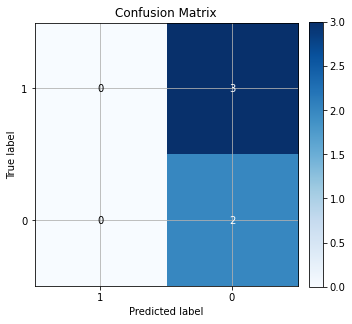

In [26]:
predictions = naive_classifier.predict(X_val)
plot_confusion_matrix(y_val, predictions, [1, 0])

In [27]:
f1_score(y_val, predictions, average='weighted')

0.2285714285714286

The Naive Bayes classifier was able to classify the two secretary jobs as non-nursing position (both appeared as true negative).
Unfortunately, the three nursing jobs were flagged as non-nursing position in this model (appeared as false negative).

The classifier in this case is not reliable as it is based on a highly unbalanced record. There are only 42 records that contain the word "nurse" in the job_title, representing only 1.4% of the records. Thus, it is unlikely that an external posting would resemble the scarce records enough to be predicted as a positive case. A larger data-set may be able to construct a model with better accuracy.